##### Import the libraries

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

##### Load the dataset

In [8]:
# Load the IMDB dataset
max_features = 10000  # Use top 10,000 words
maxlen = 100  # Cut texts after this number of words

# Load the data and labels
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [10]:
# Pad sequences to ensure consistent input size
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [11]:
x_train.shape

(25000, 100)

##### Create the transformer block

In [14]:
# Transformer block definition
def transformer_block(inputs, num_heads, ff_dim, dropout_rate):
    # Multi-head Attention Layer
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    # Feed-forward Network
    ffn_output = layers.Dense(ff_dim, activation='relu')(attention_output)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    output = layers.LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

    return output

##### Complete the model

In [20]:
# Define the full model
def create_transformer_model(input_shape, num_heads=2, ff_dim=64, dropout_rate=0.1):
    inputs = layers.Input(shape=input_shape)
    
    # Embedding layer
    x = layers.Embedding(input_dim=max_features, output_dim=ff_dim)(inputs)
    
    # Apply transformer block
    x = transformer_block(
        x, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # Dense layer for binary classification
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    # Create and compile the model
    model = models.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
model = create_transformer_model(input_shape=(maxlen,))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 64)   │    640,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 64)   │     33,216 │ embedding_2[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 100, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 100, 64)   │          0 │ dropout_9[0][0],  │
│                     │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 100, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 100, 64)   │      4,160 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 100, 64)   │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 100, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 686,017 (2.62 MB)

 Trainable params: 686,017 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from keras.utils import plot_model

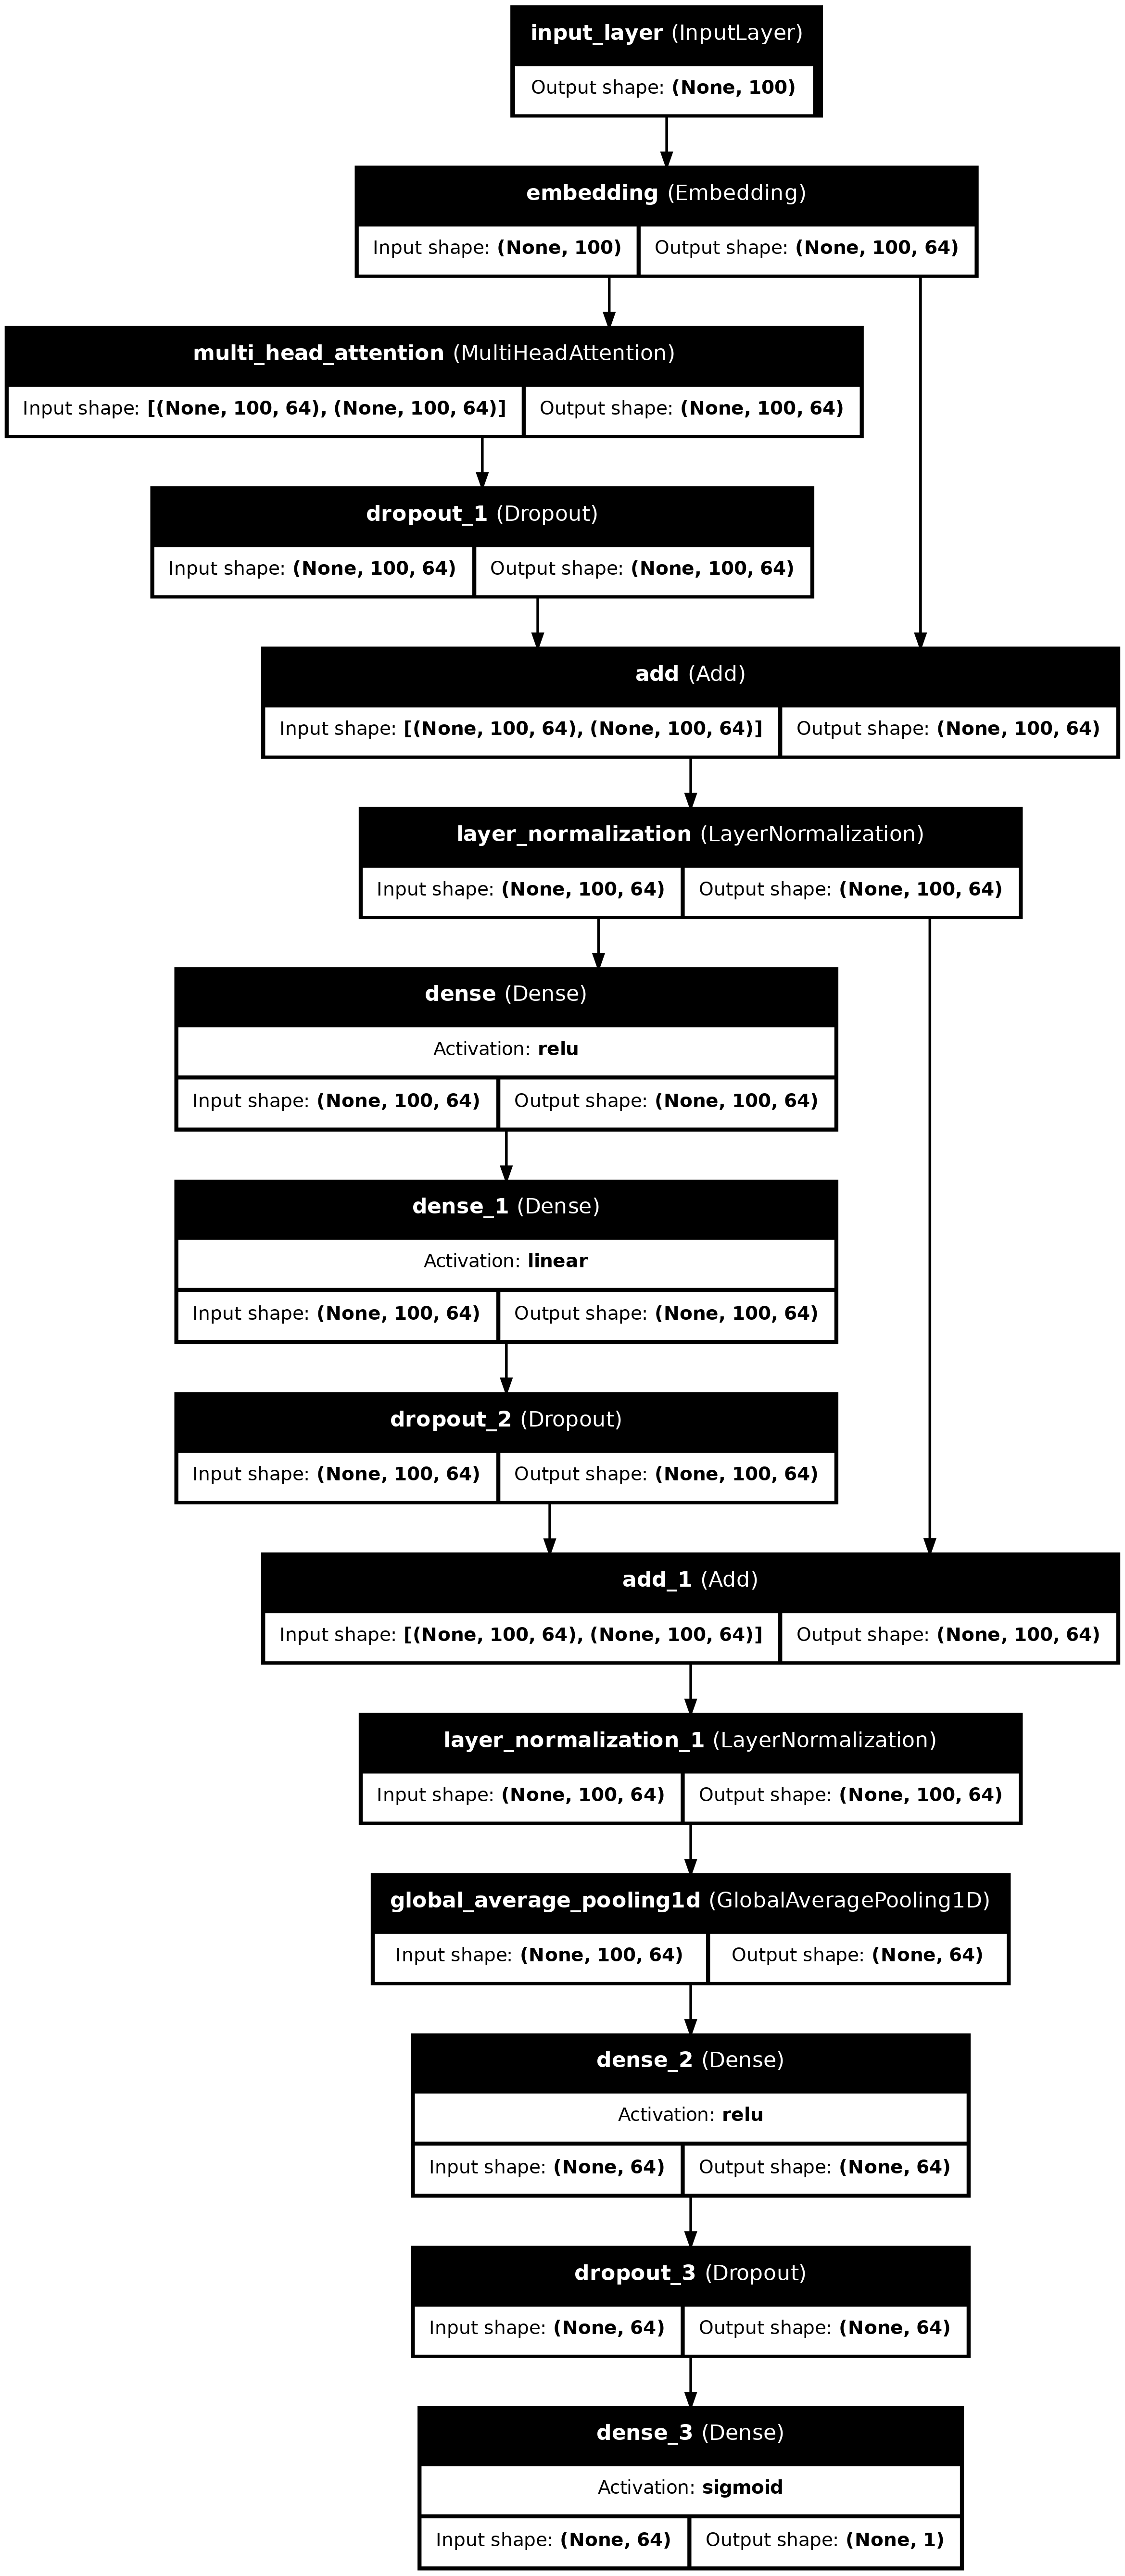

In [18]:
plot_model(model, show_layer_activations=True, show_layer_names=True,
          show_shapes=True)

##### Train the model

In [23]:
# Train the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.7539 - loss: 0.5222 - val_accuracy: 0.8304 - val_loss: 0.3733
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.8851 - loss: 0.2884 - val_accuracy: 0.8439 - val_loss: 0.3583
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.9148 - loss: 0.2305 - val_accuracy: 0.8408 - val_loss: 0.3791
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.9254 - loss: 0.2031 - val_accuracy: 0.8377 - val_loss: 0.3954
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.9387 - loss: 0.1738 - val_accuracy: 0.8338 - val_loss: 0.4377
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.9473 - loss: 0.1538 - val_accuracy: 0.8300 - val_loss: 0.4443
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.9544 - loss: 0.1421 - val_accuracy: 0.8299 - val_loss: 0.4956
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.9625 - loss: 0.1218 - 

In [25]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1)
print(f"Test Accuracy: {test_acc:.4f}")

25000/25000 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.8202 - loss: 0.5826
Test Accuracy: 0.8201


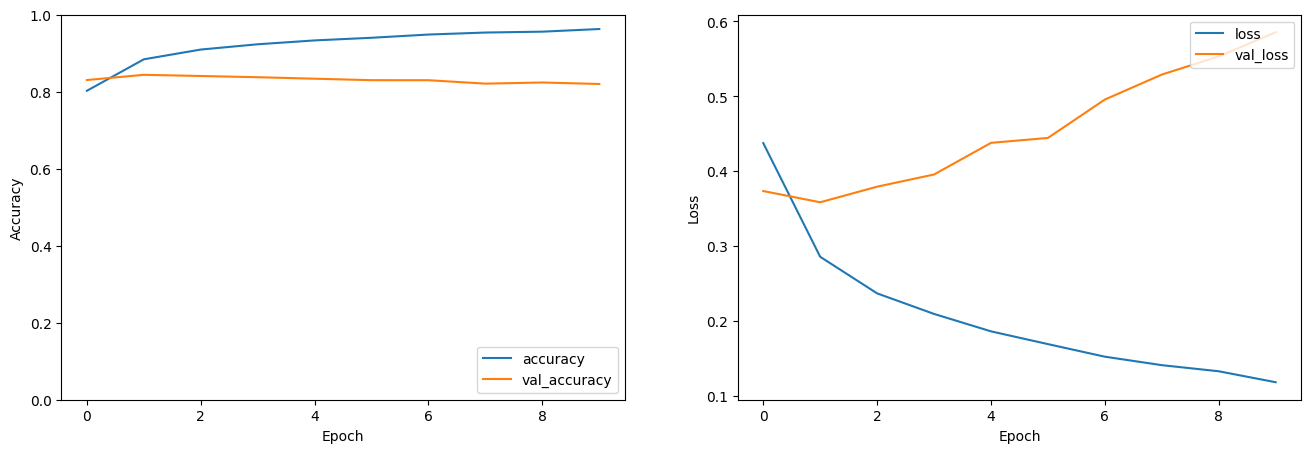

In [29]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()